### Eclipse/Light Sensor Data Analysis File
Author: Luke Docherty, Ameya Velankar and Ryan Young

Commented by Luke [and Ameya]

[Last revised by Ameya on 4/29/24]

If you have any questions or need any help, please feel free to contact me. You can reach me through the Slack [or me at ameya.s.velankar@gmail.com], I'll keep my account there after I leave and check it periodically. I am fully aware of the struggle of picking up other people's work in this project so I will try my best to make this as user friendly as possible. So I'll say again: if there's any problems/questions, don't be afraid to reach out [Good luck!].

In [101]:
#A million imports for a million different things. They are all very googlable though if you want to learn more about them.
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import os
from scipy import fft
from scipy.signal.windows import hann
from matplotlib.animation import FuncAnimation
from IPython import display
from matplotlib.lines import Line2D
from matplotlib import rcdefaults

rcdefaults()

#[Ameya's Imports]
import pandas as pd
import os
from datetime import datetime,timedelta
import warnings
import pytz
import matplotlib.colors as colors
import matplotlib.dates as mdates
import scipy



In [2]:
#READ IN DATA FOR ONE SPECIFIC FILE
#This cell will read in data from a single file with what is probably an odd name, like the one I had below made by Dr. Clark.
#The data will come out in the list 'newData'.
#The first element, 'newData[0]', is the voltage data. The second, 'newData[1]' is the time data.
#Just make sure to change the path in the below line to wherever the file is located in your computer.

path='C:/Users/lukey/LightSensorTesting/BL00 66000s to 68000s.txt'
fileVolts =  np.genfromtxt(path, usecols=0)
fileTimes = np.genfromtxt(path, usecols=1)
Data = [fileVolts,fileTimes]
newData=Data

In [4]:
#READ IN DATA FROM ORIGINAL DATA FILES
#This cell will read in data from the original files collected by the raspberry pis. The file names will look like
#'LSdate0_*.txt' in each folder. So, this cell will grab each file and add all the data together into 2 arrays. Voltage and Time.
#The data is stored in the array 'newData'. Voltage is in 'newData[0]' and time is in 'newData[0]'.
#You have to change the startindex and endindex 3 lines below this comment to whatever file you want to read in from and to. For
#example, if i want the data from files LSdate0_6.txt to LSdate0_25, I would make startindex=6 and endindex=25.
#If you use a large number of files, it will be slow.
#Make sure to change the path in the below line to wherever the folder is in your computer
directory="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/AprilEclipseData/Data/BL00/"
Data=np.zeros((2,2))
startindex=0
endindex=50


for i in range(startindex,endindex+1):
    print(i)
    path=os.path.join(directory,"LSdate0_"+str(i)+".txt")
    df=np.loadtxt(path,delimiter="\t")
    Data=np.concatenate((Data,df.T),axis=1)
print(Data)
Data[1]=Data[1]-Data[1][0]

index=2
newVData=Data[0][index:-1]
newTData=Data[1][index:-1]-Data[1][index]
newData=np.array([newVData.T,newTData.T])
print(newData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
[[ 0.00000000e+00  0.00000000e+00 -1.14328743e+00 ...  4.27485000e-03
   4.27964000e-03  4.26886000e-03]
 [ 0.00000000e+00  0.00000000e+00  1.71258951e+09 ...  1.71260511e+09
   1.71260511e+09  1.71260511e+09]]
[[-1.14328743e+00  9.69724600e-02  9.98532900e-02 ...  4.27545000e-03
   4.27485000e-03  4.27964000e-03]
 [ 0.00000000e+00  2.46787071e-03  4.81295586e-03 ...  1.55910373e+04
   1.55910397e+04  1.55910420e+04]]


In [5]:
#This cell just checks to make sure there are no odd time jumps in your data. For example, 3 seconds shouldn't come after
#4 seconds. If this cell prints anything other than 0.0, something in the data file itself is wrong. And the time value it
#printed is where you will find the error.
for i in range(len(newData[1][1:])):
    if(newData[1][i-1]>newData[1][i]):
        print(newData[1][i])

0.0


Text(0.5, 0, 'Time')

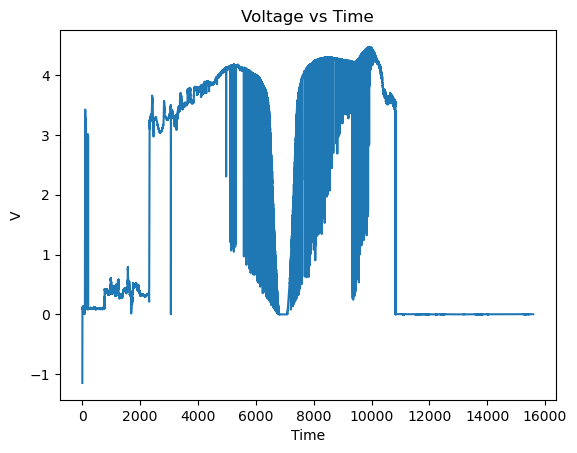

In [6]:
#An initial plotting of voltage vs time, just plots the data in volts and seconds.
#They will want to see this often, and probably in a few different ways. To zoom in on specific parts, you can use those
#xlim and ylim commands commented out at the bottom. Feel free to change those values around to zoom in on different parts.
plt.plot(newData[1],newData[0])
plt.title("Voltage vs Time")
plt.ylabel("V")
plt.xlabel("Time")
#plt.ylim(-0.0007,0)
#plt.xlim(67100,67200)

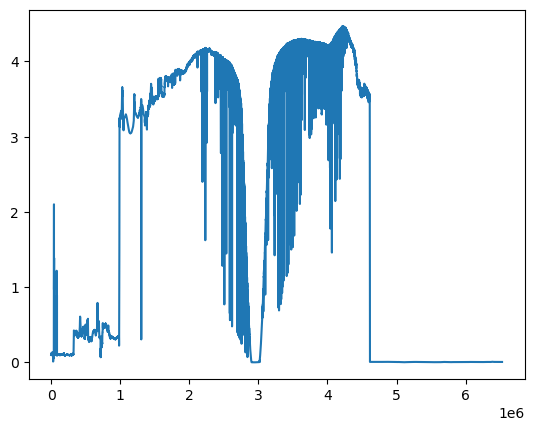

In [7]:
#This plots the voltage average over 1 second vs time but with time in the index values of the time data array. This is very useful for
#determining indices you want to use for other plots. Rather than calculating it you can look at this plot and get
#a visual estimate of where your indexs should be. The index estimate is pretty much all I use this graph for.
w=400
dStds=np.mean(np.lib.stride_tricks.sliding_window_view(newData[0], w),axis=1)
print()
plt.plot(dStds)
#plt.ylim(0,1e-5)
plt.show()

426.07720438845996


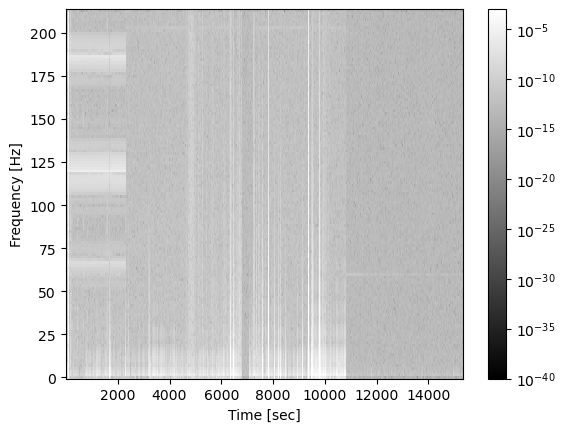

In [8]:
#PLOT THE SPECTROGRAM OF YOUR VOLTAGE AND TIME DATA
#This is an important one, the spectrogram does a discrete Fast Fourier transform to attempt to find signals in the data.
#The interesting part is that it does an FFT for a ton of steps in time from the beginning of your data to the end.
#So it shows how signals evolve from the beginning to the end of your data and its very useful for showing the signals
#around the eclipse before, during, and after totality. The y axis is the frequency of the signals, x axis is the time,
#and the colorbar tells you how strong the signals are with respect to each other.

#The main thing you need to worry about changing is the normalization in the plt.pcolormesh line. The normalization values
#determine what values the brightest and darkest colors correspond to and that's important for making the graph readable as well as
#pretty. Changing these is sort of a trial and error. If its too dark, lower vmax. If its too bright, raise vmin. Adjust until
#satisfied.
x=newData[0]
fs=1/np.median(np.diff(Data[1]))
print(fs)
f, t, Sxx = signal.spectrogram(x, fs)

plt.pcolormesh(t, f, Sxx,norm=colors.LogNorm(vmin=1e-40, vmax=1e-3),cmap="gray")
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.xlim(580, 1400)
#plt.ylim(0,30)
plt.show()


#THE CODE BELOW THIS COMMENT IS A SPECTROGRAM WITH LINEAR NORMALIZATION. THIS MIGHT BE USEFUL INSTEAD OF THE LOGARITHMIC
#COLOR SCHEME SOMETIMES. IF YOU WANNA USE IT, JUST UNCOMMENT THE 5 LINES BELOW THIS COMMENT. 

#plt.pcolormesh(t,f,Sxx,cmap="gray")
#plt.colorbar()
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.show()

In [9]:
#ROLLING STANDARD DEVIATION OF THE VOLTAGE OVER TIME
#This cell takes 1 second standard deviations over the entire data set. It can tell you the noise of the measurement
#at any point during the eclipse. THIS CELL IS FOR SMALLER DATA SETS(LESS THAN 1 MILLION POINTS), ANY MORE AND YOUR COMPUTER WILL CRY.
#Any more than that and use the cell below this. You shouldn't need to change much with this cell. 
#Unless you wanna change the limits of course.
stds=np.std(np.lib.stride_tricks.sliding_window_view(newData[0], 420),1)
plt.plot(newData[1][0:len(stds)],stds, 'b.', markersize = 0.01)
plt.ylim(-0.001, 0.01)
plt.yscale("linear")
plt.title("Rolling Standard Dev.")
plt.ylabel("V")
plt.xlabel("t(s)")
info = " BL00 April" 
plt.figtext(0.91,0.69,info)
plt.show()

KeyboardInterrupt: 

In [ ]:
#A quick cell to determine how many points are in your data set. Need this number for the next cell
print(len(newData[0]))

In [ ]:
#ROLLING STANDARD DEVIATION OF THE VOLTAGE OVER TIME(LARGE DATA SETS)
#Same as above but for larger sets of data(usually over a million points). The number you get from the above cell,
#round it down to the nearest million to use below. FOR EXAMPLE, if i have 3.78 million data points I will make the first line:
#for i in range(3), if I have 5.12 million data points, i will make it: for i in range(5), and so on.
#This is a little more complicated, but it really really eases the stress on your computer's memory. Still takes a while to run though.
for i in range(1):
    stds=np.std(np.lib.stride_tricks.sliding_window_view(newData[0][0+1000000*i:1000000+1000000*i], 300),1)
    plt.plot(newData[1][0+1000000*i:len(stds)+1000000*i], stds, 'b.', markersize = 0.01)
plt.ylim(-0.01, 0.03)
plt.yscale("linear")
plt.title("Rolling Standard Dev.")
plt.ylabel("V")
plt.xlabel("t(s)")
info = " PL00 April Data" 
plt.figtext(0.91,0.69,info)
plt.show()
print(f'{np.average(stds[120000:]): .2e} V')

In [ ]:
#SIGNAL TO NOISE OF THE DATA
#This cell is pretty simple. Just takes the signal value and the standard deviation value and divides them. They might ask
#for the signal to noise of the data sometimes. This is a pretty good estimate. Obviously, it acts a little weird during totality,
#but that's expected. Shouldn't have to change anything in this unless you wanna zoom in on different parts you can change limits.
SN=[0.0]*len(stds)
for i in range(len(stds)):
    SN[i] = newData[0][i]/stds[i]
plt.plot(newData[1][:len(stds)], SN)
plt.yscale('log')
plt.xlabel('Time(s)')
plt.ylabel('S/N')
plt.title('BL00')
#plt.ylim(1e-200, 1e5)

In [ ]:
#GENERATE FFT
#This cell makes an FFT of the data from the start index in time to the end index in time. You can change those as you'd like.
#Because the indices need cut in half during the calculations, try to keep (end-start) an even number. Everything should work smoothly
#if thats the case. Feel free to change the limits and scale. The yscale is currently set to logarithmic, you can set to linear if
#you'd like but its usually much easier to plot logarithmically
start = 600000
end = 700000
ft = fft.fft(newData[0][600000:700001])
N = end-start

#Create and calculate the power spectrum with the magnitude squared of the coefficients
power_spectrum = [0.0]*N
for i in range(N):
    power_spectrum[i] = abs(ft[i])**2

#PLOT FFT
# Calculate Nyquist freq and resolution in 1/years
fNy = 1/(2*0.00238)
df = 1/(N*0.00238)

#Calculate frequency spread
f = np.arange(0, fNy, df)

window = hann(801)
#Create figure, and plot the frequency and power spectrum
plt.figure(figsize=(15,4))
plt.plot(f, power_spectrum[:int((end-start)/2)])

#Create plot labels and adjust limits
plt.xlabel("Frequency(Hz)")
plt.ylabel("Power Spectrum")
plt.title("FFT")
plt.xlim(0,100)
#plt.ylim(0,0.01)
#plt.xscale("log")
plt.yscale("log")
plt.figtext(0.91,0.69,info)
#Add grid
plt.grid()
#Show plot
plt.show()

In [ ]:
#GENERATE VIDEO OF 1 SEC FFTS OVER DATA
#Saved the worst for last. This cell generates a video of 1 second FFTs over a designated period of time. I've posted some in the
#slack before so you can use those as an example of what they look like. Essentially, you can pick a starting index in your data array,
#this acts as a starting time for your video. Then, you can pick a timestep. Since there is about 420 indices per second, if you leave
#timestep=420, every frame of the video will represent a 1 second jump. If timestep=210, then every frame represents half a second in
#the data. If timestep=42, then every frame represents 1/10th of a second in the data. And so on.
#Usually, 1 second a frame(timestep=420) and 1/10th second a frame(timestep=42) should be all you need.
#This just changes how often it takes 1 second wide FFTs. The FFTS will always be 1 second wide unless you do a lot of changing with
#the code. (Contact me if you want to do that and are unsure.)

#Currently, the video autoscales the FFTs over time, so the y scale values jump around. Look for my comment below to explain
#what line to comment out if you want to stop autoscaling. If you do stop it, you can add your own xlim in to use some static value.

#Feel free to change the limits of either graph below, subplot(2,1,1) is the voltage vs time to show where the FFT is being taken,
#subplot(2,1,2) is the FFT itself. So you can change limits for each respectively under the respective subplot lines.

#Final comment is the total number of frames in the video. Look below for my comment about the frame number. Essentially, 
#the timestep of your video and the number of frames will determine how much of the time data it will go through.
#If the timestep is 1 second and you have 1000 frames, it will go through 1000s of data. If the timestep is 1/10th of a second,
#and you have 1000 frames, it will go through 100s of data. So its pretty easy to calculate.
fig, axes = plt.subplots(2,1) #Create 1x2 grid of subplots
fig.tight_layout(pad=2.0)

startingindex=450000
timestep = 42 #1 sec is 420
ft = fft.fft(newData[0][startingindex:startingindex+420])
N = 420


#Create and calculate the power spectrum with the magnitude squared of the coefficients
power_spectrum = [0.0]*N
for i in range(N):
    power_spectrum[i] = abs(ft[i])**2

#PLOT FFT
# Calculate Nyquist freq and resolution in 1/years
fNy = 1/(2*0.00238)
df = 1/(N*0.00238)

#Calculate frequency spread
f = np.arange(0, fNy, df)

window = hann(210)
#Create figure, and plot the frequency and power spectrum
plt.subplot(2,1,1)
light, = plt.plot(newData[1], newData[0])
time = plt.axvline(startingindex/420, 0, 3.3,color = 'red')
plt.ylim(0,4.3)
plt.xlim(np.min(newData[1]), np.max(newData[1]))
plt.xlabel('Time(s)')
plt.ylabel('Voltage(V)')
plt.title('BL01')

plt.subplot(2,1,2)
line, = plt.plot(f, power_spectrum[:210]*window)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Power')
#plt.ylim(0,1.6e-2)
plt.xlim(0,30)

#Define animation function
def animate(frame):
    #Update the 1 sec fft by a tenth of a second with every frame and update the red line for every frame
    ft = fft.fft(newData[0][startingindex+frame*timestep:(startingindex+420)+frame*timestep])
    for i in range(420):
        power_spectrum[i] = abs(ft[i])**2
    line.set_data(f,power_spectrum[:210]*window)
    time.set_xdata(newData[1][0] + startingindex/420 + (timestep*frame/420))
    plt.subplot(2,1,2)
    #AUTOSCALE LINE, COMMENT THE BELOW LINE OUT IF YOU WANT TO STOP AUTOSCALE
    plt.ylim(0, 1.5*np.max(power_spectrum[:210]*window))
    
#FRAME LINE, you can change the total number of frames below, combine this with the timestep to figure out how many seconds of
#data the video will present.
#If you want the frames to change more slowly, you can increase the variable interval, its in milliseconds.
anim = FuncAnimation(fig, animate, frames=1000, interval=200)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Now adding Ameya's code

##### I deeply apologize that you have to go through all of this. I do not envy you. May god have mercy on your soul.

Most of the first cells can be ignored. They are just to import the data. You can jump to the IV Curve section if you want

Most of my code is very similar to Luke's. However, I wrote most things as functions so it's easier to iterate through file folders.


In [2]:
#Alternative Import Code that allows you to run iterations over many different folders at once
#Basically just the same thing that Luke did but as packaged functions

directory="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/AprilEclipseData/Data/"
folder=os.listdir(directory)
    
#This is only used if you are loading in from multiple files. I recommend you combine the pertinent data into
#one file (Russell has already done this+synchronized) and then use the onefile function below, 
def getData(path):
    Data=np.zeros((2,2))
    folder=os.listdir(path)
    foldernums=np.array([])
    for i in folder:
        foldernums=np.append(foldernums,i[8:-4]).astype(int)
    foldernums=np.sort(foldernums)
    end=foldernums[-1]
    for i in foldernums:
        pathS=path+"LSDate0_"+str(i)+".txt"
        if(i==end):
            df=np.genfromtxt(pathS,delimiter="\t",skip_footer=1,invalid_raise=False) #The invalid_raise takes care of line breaks by just ignoring them lol
            Data=np.concatenate((Data,df.T),axis=1)
        else:
            df=np.genfromtxt(pathS,delimiter="\t",invalid_raise=False)
            Data=np.concatenate((Data,df.T),axis=1)
    return Data


#Not used - included for historical reasons (was previously used to remove first several points from data set)
def removeStart(data):
    index=3 #2 would probably work, but who cares
    newVData=data[0][index:-1]
    #newTData=data[1][index:-1]-data[1][index]
    newTData=data[1][index:-1]
    newData=np.array([newVData.T,newTData.T])
    return newData


#Used if the data is all in one file
def getDataOneFile(filepath):
    df=np.genfromtxt(filepath,delimiter="\t",skip_footer=1,invalid_raise=False)
    return df


In [104]:
title="BL01" #Basically just for titles and for getting the right files
payload=str(1) #00 and 01 were on Payload 1. 02/03 were on Payload 2. You can change this to str(2) for payload 2

#Use if importing from original files
#pathS=directory+title+"/"
#Data_with_start=getData(pathS)

#Importing from Russells' synchronized files
p="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/AprilEclipseData/Data/"+title+"UTC.txt"
Data_with_start=getDataOneFile(p)

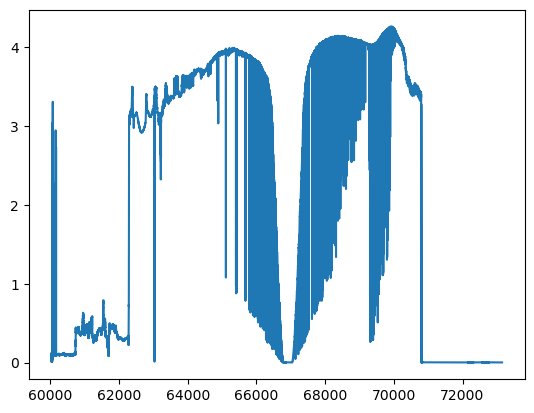

In [32]:
# You need to transpose the data for it to work
#The following timing code is for russell's data where UTC is already synchronized and the origin is midnight on eclipse day
#If importing for original data, the origin is 1/1/1970 so adjust accordingly (mainly by commenting out the lines that set day/month/year)
Data=Data_with_start.T
plt.plot(Data[1],Data[0])

In [33]:
#Convert to RTC time and subtract timedelta for timezone
#Using RTC time is often more trouble than it's worth which is why ztime is also included (which starts at 0)
#I use RTC time mostly since I'm doing alot of synchronization in this
RTCTime=(pd.to_datetime(pd.DataFrame(Data[1])[0],unit="s",utc=True)-timedelta(hours=5)).to_numpy()
#RTCTime.to_pandas
zTime=Data[1]-Data[1][0]

In [34]:
#Puts Russells synced files on the correct day/month/year
def setTime(date):
    return date.replace(year=2024,day=8,month=4)
setTime=np.vectorize(setTime)
RTCTime=setTime(RTCTime)

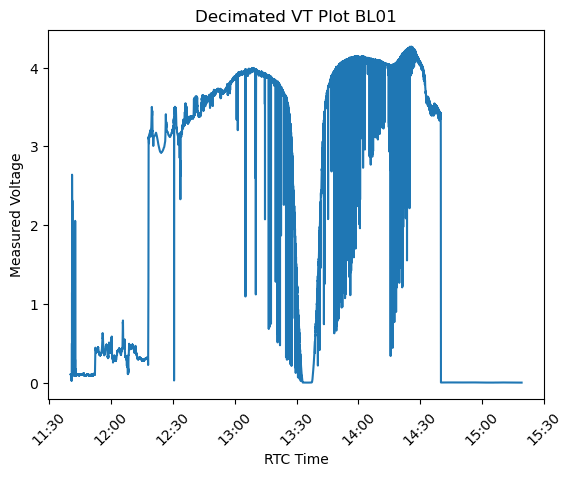

In [35]:
#If your computer is having trouble plotting quickly, this takes a subset of those points and plots it 
#to be faster
def quickPlot(x,y,n):
    if (len(x)!=len(y)):
        print("Error")
        pass
    inds=np.linspace(0,len(x)-1,n).astype(int)
    return x[inds],y[inds]

fig, ax = plt.subplots()
ax.plot(*quickPlot(RTCTime,Data[0],20000))
#ax.plot(RTCTime,Data[0])
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("RTC Time")
plt.ylabel("Measured Voltage")
plt.title("Decimated VT Plot " + title)
plt.show()
#plt.plot(zTime,Data[0])

## IV CURVE SECTION

I am not the best person to ask on how the IV cuves were collected. Luke or Norris (but probably Luke) knows better. To the best of my recollection, this is what we did:

IV Curves were collected by creating a triangle wave on the function generator at a 5Hz frequency. The following values were used (differential output)
-Small (-60mv->190mv)
-Medium (-60mv->1.14V)
-Large (-60mv->6.94V)
The 1e3 resistor on the board converts it to current (note that this board has two seperate "grounds", getting them twisted will lead to confusion)

Then using the oscilloscope, we measured the voltage response of the circuit. Note that because of impedance weirdness, we couldn't measure the input and output simeltaneously. Hence all the "synchronization" that you'll see below.

You will note that the results below (from the oscilloscope) are extremely noisy. You should probably repeat the measurement using the Pi ADC for a more accurate result. Otherwise, once you propogate the error, you're not going to be too happy with the result of "delogarithmicification"

In [4]:
#Get IV Curve Oscilloscope files. There are multiple files for some reason. I don't really know why...
warnings.filterwarnings("ignore")
IVDirec="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/IV_CURVES/"+title
files=os.listdir(IVDirec)

#The format of the scope file is hell. This just gets the correct file from the parent folder
def readScopeFile(name):
    f=open(name,"r")
    #print(f.read())
    return np.genfromtxt(name,invalid_raise=False,delimiter=',')
    f.close()

tdata1,vdata1=readScopeFile(IVDirec+"/"+files[0]).T[3:5] #These are the useful columns in the format time,voltage
warnings.filterwarnings("default")

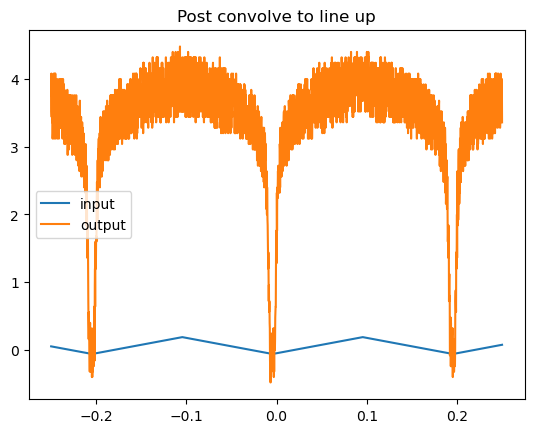

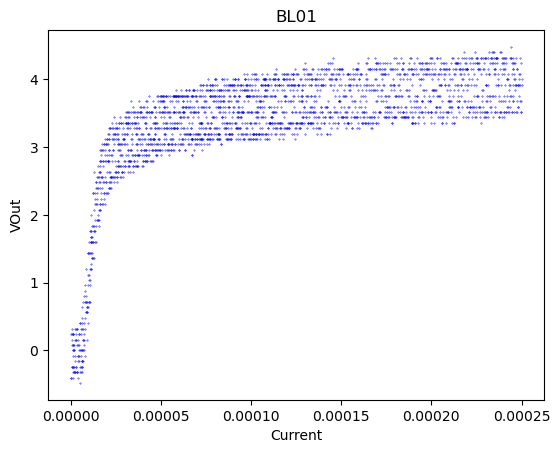

In [26]:
#Ryan wrote most of this cell so I will try to summarize
#We plugged in a triangle wave into the circuit, so we get back some weird m shape.
#Then we find the minimum of the output and assume that to be the origin
#thus we have the input/output waveforms

#this creates the imitation of the input triangle wave
def triangleWave(t,Hz,mi,ma):
    return (ma-mi)*(scipy.signal.sawtooth(2 * np.pi * Hz * t,width=0.5)+1)/2+mi

#This is a naive approach to lining up. We take a rolling sum to find a nice minimum point and set
#that as the new origin by shifting over
smoothing = 50
shiftby1=tdata1[np.argmin(scipy.signal.convolve(vdata1,np.ones(smoothing),mode="same"))]

waveform1=triangleWave(tdata1-shiftby1,5,-60e-3,190e-3)

plt.plot(tdata1,waveform1,label="input")
plt.plot(tdata1,vdata1,label="output")
#plt.xlim(-0.02,0.02)
#plt.ylim(-0.1,0.1)
plt.legend()
plt.title("Post convolve to line up")
plt.show()
curr=(waveform1+60e-3)/1e3 
plt.scatter(curr,vdata1,s=0.1,c="blue")

plt.xlabel("Current")
plt.ylabel("VOut")
plt.title(title)
plt.show()

### Fitting Models
Nobody really knows which model to use. Below is a piecewise with a sigmoid switch to force smoothness. There is a physical model (for an earlier version of the circuit, I haven't done one for the most recent version) that you can get just through op-amp algebra and Shockley's equation (assume the 3 diodes act as one). Dave Turnshek has the derivation of this formula via a conversation I had with Istvan over Slack.

The formula for a one stage logarthmic amplifier is $(i_{photo}+i_{dark})R_{gain}-i_{dark}(R_{gain}e^{V_{out}/{(n V_{t})}})=V_{out}$


In any case, the fact that there is so much noise means that almost any reasonable model will work well enough.

[ 1.56772220e-05  1.00000000e+06  1.56269616e+05 -4.95102879e-01
  4.26557469e-01  7.50299649e+00  7.27194924e-08]


C:\Users\ameya\AppData\Local\Temp\ipykernel_14544\3198337427.py:9: RuntimeWarning: divide by zero encountered in log
  return ((1-alpha)*(a1*x + b1)) + ((alpha)*(a2*np.clip(np.log(x),-1e6,None) + b2))
C:\Users\ameya\AppData\Local\Temp\ipykernel_14544\3198337427.py:9: RuntimeWarning: invalid value encountered in log
  return ((1-alpha)*(a1*x + b1)) + ((alpha)*(a2*np.clip(np.log(x),-1e6,None) + b2))


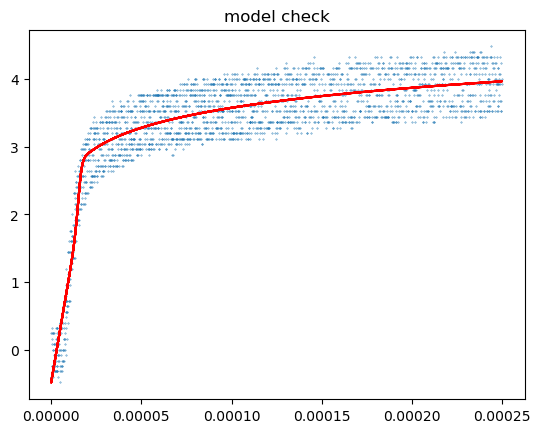

In [27]:
#Now we fit models to the data

def lin_log(x,switch,sharpness,a1,b1,a2,b2,x0):
    x = np.array(x)
    x0=float(x0)
    x=x+x0
    switch,sharpness,a1,b1,a2,b2 = float(switch),float(sharpness),float(a1),float(b1),float(a2),float(b2)
    alpha = 1 / (1 + np.exp(sharpness * ((-1*x)+switch)))
    return ((1-alpha)*(a1*x + b1)) + ((alpha)*(a2*np.clip(np.log(x),-1e6,None) + b2))


args_linlog = scipy.optimize.curve_fit(lin_log,curr,vdata1,p0=[0.00002,1000000,50000,0,0.3,5.62,0],maxfev=99999,bounds=([0,1e6,0,-np.inf,0,-np.inf,-1],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1]))[0]
print(args_linlog)
plt.plot(curr,lin_log(curr,*args_linlog),color="red")
plt.scatter(curr,vdata1,s=0.1)
plt.title("model check")
plt.show()

In [104]:
#I don't really remember why I added this cell tbh, but I left it in just in case. 
IVmapping=np.linspace(-1e-5,1e-3,10000)
CorespV=lin_log(IVmapping,*args_linlog)
print(min(CorespV[~np.isnan(CorespV)]))

-0.48373886840304414


C:\Users\ameya\AppData\Local\Temp\ipykernel_21604\1720948579.py:7: RuntimeWarning: invalid value encountered in log
  return ((1-alpha)*(a1*x + b1)) + ((alpha)*(a2*np.clip(np.log(x),-1e6,None) + b2))


In [106]:
#THis is used to convert the voltage we get to current incident on the photodiode.
#For this we need the inverse function as before
#You could also fit the inverse to begin with, but it's less intuitive 
#Note that for some models I tried, a closed form isn't possible without complicated functions
#Therefore, a dictionary-esque system is used, with a table of Voltage-current conversions.
#Hence the need for the interpolate function to fill in the dictionary blank spaces
#If your computer is faster than mine (a low bar to surpass), you can probably just convert directly


shortData=quickPlot(Data[0],RTCTime,10000) #get the subset of data to convert

#interpolate between dictionary points assuming linearity
def interpolate(x):
    index=np.where(CorespV<x)[0][-1]
    locInInterval=(x-CorespV[index])/(CorespV[index+1]-CorespV[index])
    out=IVmapping[index]+(IVmapping[index+1]-IVmapping[index])*locInInterval
    return out

#take voltage array and give back corresponding circuit current array for the dictionary
def mapVtoI(VArr):
    i=np.array([])
    for v in shortData[0]:
        i=np.append(i,interpolate(v))
    return i

shortI=mapVtoI(shortData[1])

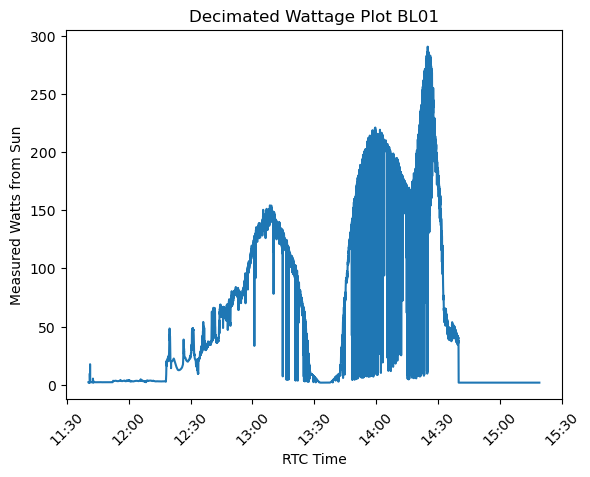

In [86]:
#Convert current to wattage
#Use photosensitivity of 0.3 A/W 2.4mm size 
WattsIncident=shortI/0.3
WattsPerSqMeter=WattsIncident/((2.4e-3)**2)

fig, ax = plt.subplots()
ax.plot(shortData[1],WattsPerSqMeter)
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("RTC Time")
plt.ylabel("Measured Watts from Sun")
plt.title("Decimated Wattage Plot " + title)
plt.show()


In [87]:
#Get Altitude data and add correct timestamp
file2="C:/Users/ameya/OneDrive - University of Pittsburgh/Eclipse/DataFiles/AprilEclipseData/Payload"+payload+".csv"
mod2=pd.read_csv(file2,delimiter=",")
mod2["Time-UTC"]=pd.to_datetime(mod2["Time-UTC"],utc=True)-timedelta(hours=5)
mod2["Time-UTC"]=mod2["Time-UTC"].apply(lambda dt: dt.replace(day=8,month=4))
#display(mod2)

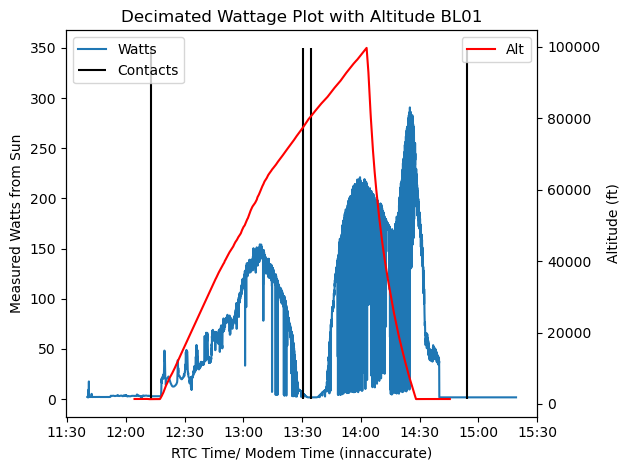

In [107]:
#Now we superimpose altitude and V-T plots. This is important because we need to make sure we are above
#turbulent layers during relevent times.

#Contact times were estimated by Clark
contacts=[datetime(2024, 4, 8,12,13,0,0,pytz.UTC),datetime(2024, 4, 8,13,30,20,0,pytz.UTC),
          datetime(2024, 4, 8,13,34,45,0,pytz.UTC),datetime(2024, 4, 8,14,53,56,0,pytz.UTC)]

fig, ax1 = plt.subplots()
ax1.plot(shortData[1],WattsPerSqMeter,label="Watts")
ax1.set_xlabel('RTC Time/ Modem Time (innaccurate)')
ax1.set_ylabel("Measured Watts from Sun")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.vlines(contacts,0,350,color="black",label="Contacts")



ax2 = ax1.twinx()
ax2.set_ylabel("Altitude (ft)")
ax2.plot(mod2["Time-UTC"].to_numpy(),mod2["Alt-ft"].to_numpy(),color="red",label="Alt")

plt.title("Decimated Wattage Plot with Altitude " + title)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

## SPECTOGRAMS!

Luke explained what a spectogram is, I'll expand. A spectogram is a bunch of FFTs. The FFT is a computer implementation of the Discrete Fourier Transform. The DFT is itself a subset of the z-transform, a very important concept in Digital Signal Processing. 
##### The key difference between the DFT and the z-transform is the DFT assumes uniform frequency samples.
This is what makes the FFT so efficient. It is also why when Dr. Turnshek asks for both smaller frequency bins and smaller time bins, you tell him it's impossible. You can only test as many frequencies as there are points in your FFT. Those frequency points are uniformly distributed between 0 and the nyquist. Remember, there is no such thing as frequency "bins". There are only frequency points.

There are ways around this. For one, the chirp z-transform allows a testing of any number of discrete frequencies. By the time I found out about it, I did not have time to investigate further. You could also attempt a least-squares approach. Lomb-Scargle is a good first option. Finally, non-uniform fourier transforms are probably the most ideal since we have time data, and our data collection is not that uniform in time (an assumption of DFT). These are best implemented in matlab

When using spectograms, we normally use scipy.spectogram because it's simplest. Make sure you remember that these spectograms have sample overlap, windowing by default, and we enable linear detrending. What we really should be doing is quadratic detrending however.

AVG TIME BTWN SAMPLES:0.0023618535426127287
SHOULD BE ABOUT: 0.002352941176470588


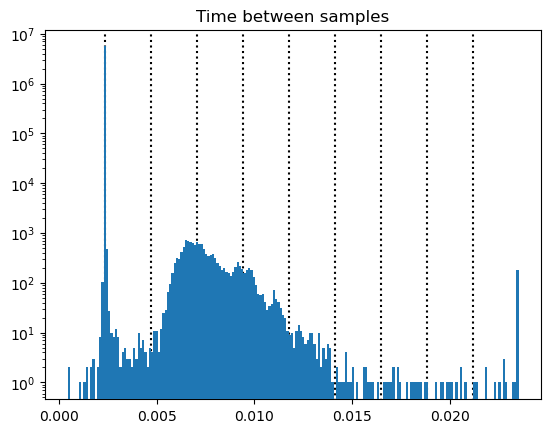

In [76]:
#Here I want to check that the datapoints are evenly distributed in time. They are not as evenly 
#distriubted as I would like :( That's why least squares methods of Non-uniform FFTs (which include time data)
#need be explored
dif=np.diff(Data[1])
print("AVG TIME BTWN SAMPLES:" + str(np.mean(dif)))
print("SHOULD BE ABOUT: " + str(1/425))
x=np.arange(0,len(dif),1)
#plt.scatter(x,np.diff(Data[1]),s=3)
plt.yscale("log")
plt.vlines(np.arange(1,10,1)*1/425,0,1e7,color="black",linestyle="dotted")
plt.hist(np.clip(dif,0,10*1/425),bins=200,zorder=10) #denotes multiples of the sampling frequency
plt.title("Time between samples")
plt.show()

In [77]:
#Just do a spectogram on the relevent portion. Remember that the log compression will distort 
# the true spectrum when the diodes are on. (mainly by creating new harmonics probably)

#Payload 2
#startspec=contacts[1]-timedelta(minutes=5)
#endspec=contacts[2]+timedelta(minutes=10)

#Payload1
startspec=datetime(2024, 4, 8,13,30,0,0,pytz.UTC)#contacts[2]-timedelta(minutes=3)
endspec=datetime(2024, 4, 8,13,40,0,0,pytz.UTC)#contacts[2]+timedelta(minutes=5)

startind=np.where(RTCTime>startspec)[0][0]
endind=np.where(RTCTime<endspec)[0][-1]

In [78]:
#print(startind,endind)
clippedT=RTCTime[startind:endind]
clippedV=Data[0][startind:endind]

In [79]:
fs=1/np.median(np.diff(Data[1]))
print(fs) #get resistant sampling rate
nps=2*256 #Number of points in each FFT. Recall that the true number of points will be nps+nps//8 bc overlap
f, t, Sxx = signal.spectrogram(clippedV, fs,nperseg=nps,detrend="linear",scaling="density")
newt=np.array([clippedT[0]+timedelta(seconds=i) for i in t])
print("df: "+ str(fs/nps)) #space between frequency points
print("dt: " + str(nps/fs)) #how long is each fft for
print((fs/nps)*(nps/fs)) #Uncertainty relation


426.07720438845996
df: 0.8321820398212109
dt: 1.20166015625
1.0


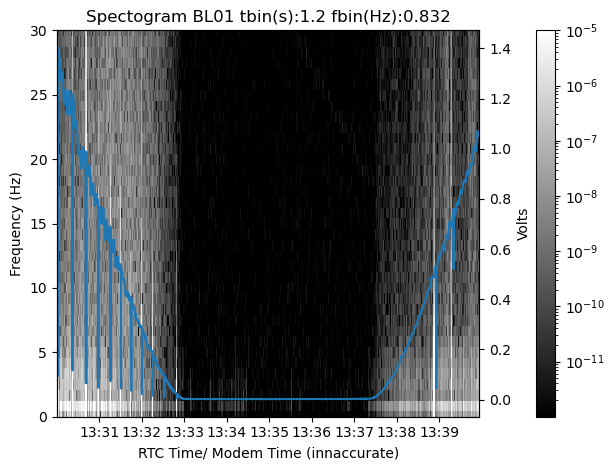

In [93]:
#Similar spectogram code to Luke's

fig, ax1 = plt.subplots()
#Plot in log scale
pcm=ax1.pcolormesh(newt, f, Sxx,norm=colors.LogNorm(vmin=Sxx.min()+1e-12, vmax=Sxx.min()+1e-5),cmap="grey")

#plot in linear scale
#pcm=ax1.pcolormesh(newt, f, Sxx,cmap="gray",vmin=Sxx.min()+1e-11,vmax=Sxx.min()+1e-9)

ax1.set_ylabel("Frequency (Hz)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(pcm, ax=ax1,pad=0.1)
ax1.set_xlabel('RTC Time/ Modem Time (innaccurate)')
ax1.set_ylim(0,30)

#Speaking of the drop outs due to the payload line, those should only show up at the higher frequencies,
#I'm not quite sure why this is not the case)
ax2 = ax1.twinx()
ax2.set_ylabel("Volts")
ax2.plot(clippedT,clippedV,label="Watts")


plt.title("Spectogram " + title +" tbin(s):" +str(round(nps/fs,1)) + " fbin(Hz):" + str(round(fs/nps,3)))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### SNR CALCULATION

The usage of standard deviation has always confused me because smaller windows=smaller stdev=larger SNR (because the mean isn't constant). We really should be using standard error I think because the voltage is changing so we can't calculate standard devation over the entire sample.

In [98]:
w=150 #This is the number of points being considered in each standard deviation
stds=np.std(np.lib.stride_tricks.sliding_window_view(clippedV, w),axis=1)
mns=np.mean(np.lib.stride_tricks.sliding_window_view(clippedV, w),axis=1)

In [99]:
SNR=mns/stds

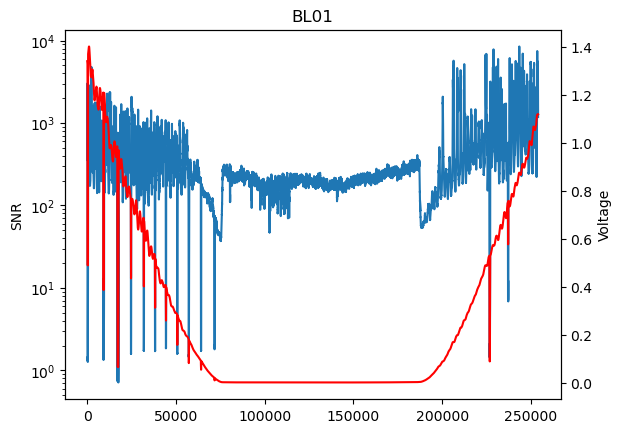

In [100]:
#Overlay plot of the means and the standard deviations in each window.
fig, ax1 = plt.subplots()
x=np.linspace(0,len(stds)-1,len(stds))
ax1.plot(x,SNR)
ax1.set_yscale("log")
ax1.set_ylabel('SNR')

ax2 = ax1.twinx()
ax2.plot(x,mns,color="red")
ax2.set_ylabel('Voltage')

plt.title( title)

plt.show()

### ADD A FAKE SIGNAL

In [53]:
#print(startind,endind)
clippedT=RTCTime[startind:endind] #Get pertinant RTC time data to overlay plot
clippedTTT=Data[1][startind:endind] #get pertinant time data to actually run data on
clippedV=Data[0][startind:endind] #get pertinant voltage data

(0.002, 0.003)

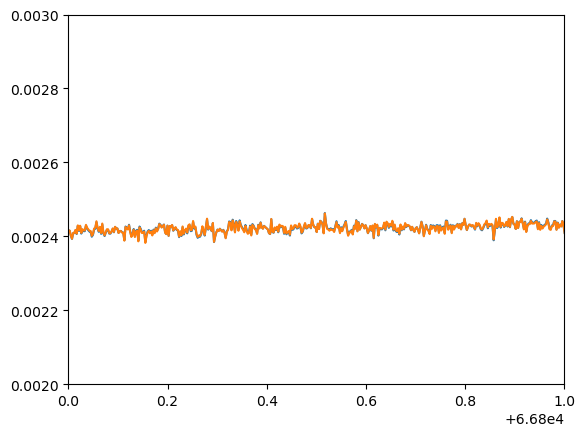

In [111]:
plt.plot(clippedTTT,clippedV) #plot original data

#adds a 0.1% 5hz sine wave to the signal
#A clean signal will be very easily detected. There are three ways to add noise.
#1. add blatant random noise to signal
#2. add a tiny bit of random noise to the amplitude
#3. add a tiny bit of random noise to the frequency (most realistic)
#you'll find that the FFT is least tolorent to noise type 3.
def sine(t,v):
    return 1e-3*v*np.sin(((5*2*np.pi*t)))


sinedV=clippedV+sine(clippedTTT,clippedV)

plt.plot(clippedTTT,sinedV)
plt.xlim(66800,66801)
plt.ylim(0.002,0.003)

In [112]:
#Same spectogram code as before
fs=1/np.median(np.diff(Data[1]))
print(fs)
nps=8*256
f, t, Sxx = signal.spectrogram(sinedV, fs,nperseg=nps,detrend="linear",scaling="density")
newt=np.array([clippedT[0]+timedelta(seconds=i) for i in t])
print("df: "+ str(fs/nps))
print("dt: " + str(nps/fs))
print((fs/nps)*(nps/fs))

426.07720438845996
df: 0.20804550995530272
dt: 4.806640625
1.0


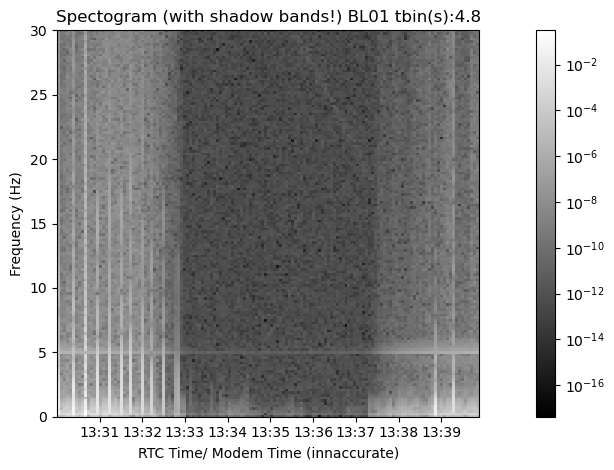

In [114]:
fig, ax1 = plt.subplots()
pcm=ax1.pcolormesh(newt, f, Sxx,norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()),cmap="grey")
#pcm=ax1.pcolormesh(newt, f, Sxx,norm=colors.LogNorm(vmin=Sxx.min()+1e-11, vmax=Sxx.min()+1e-7),cmap="grey")
#pcm=ax1.pcolormesh(newt, f, Sxx,cmap="gray",vmin=Sxx.min()+1e-11,vmax=Sxx.min()+1e-9)
ax1.set_ylabel("Frequency (Hz)")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.colorbar(pcm, ax=ax1,pad=0.1)
ax1.set_xlabel('RTC Time/ Modem Time (innaccurate)')
ax1.set_ylim(0,30)


#ax2 = ax1.twinx()
#ax2.set_ylabel("Volts")
#ax2.plot(clippedT,clippedV,label="Watts")


plt.title("Spectogram (with shadow bands!) " + title +" tbin(s):" +str(round(nps/fs,1)))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()